# Preventing Overfitting

In the last few weeks we discussed the idea of **overfitting**,
where a neural network model learns about the quirks of the training data,
rather than information that is generalizable to the task
at hand. We also briefly discussed idea of **underfitting**, but not in as much depth.

The reason we did not discuss underfitting much is because nowadays,
practitioners tend to avoid underfitting altogether by opting for more
powerful models. Since computation is (relatively) cheap,
and overfitting is much easier to detect, it is more straightforward
to build a high-capacity model and use known techniques to prevent
overfitting. So, always start with slightly more *capacity* than you need,
then use some of the many strategies to prevent overfitting.

We've actually already discussed several strategies for detecting overfitting:

- Use a larger training set
- Use a smaller network
- Weight-sharing (as in convolutional neural networks)
- **Early stopping**
- **Transfer Learning**

Some of these are more practical than others. For example, collecting a larger training
set may be impractical or expensive in practice. Using a smaller network means that we need
to restart training, rather than use what we already know about hyperparameters and appropriate
weights.

**Early stopping** was introduced in lab 2,
where we did not use the trained weights from the last training iteration
as our ``final'' model.
Instead, we used a model (a set of weights) from a previous
iteration of training. We chose the iteration/epoch to use based on
the training curve.

**Transfer learning** was introduced in lab 3, where we used
pre-trained weights of a different model (e.g. AlexNet)
as part of our neural network.
The architectures and weights of AlexNet was trained using a larger 
dataset, and was trained to solve a different image classification problem.
Nevertheless, transfer learning allows us to leverage information
from larger data sets with low computational cost.

These are only some of the techniques for preventing overfitting. We'll discuss more techniques today,
including:

- Data Normalization
- Data Augmentation
- Weight Decay
- Model Averaging
- Dropout

We will use the MNIST digit recognition problem as a running example. Since we are studying overfitting,
I will artificially reduce the number of training examples to 200.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# for reproducibility
torch.manual_seed(1)

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)
mnist_train = mnist_data[:20]     #  20 train images
mnist_val   = mnist_data[100:5100] # 2000 validation images

We will also use the `MNISTClassifier` from the last few weeks as our base model:

In [3]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = F.relu(self.layer1(flattened))
        activation2 = F.relu(self.layer2(activation1))
        output = self.layer3(activation2)
        return output

And of course, our training code, with minor modifications that we will explain as we go along.

In [4]:
def train(model, train, valid, batch_size=20, num_iters=1, learn_rate=0.01, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    while True:
        if n >= num_iters:
            break
        for imgs, labels in iter(train_loader):
            model.train() #*****************************#
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            if n % 10 == 9:
                iters.append(n)
                losses.append(float(loss)/batch_size)        # compute *average* loss
                train_acc.append(get_accuracy(model, train)) # compute training accuracy 
                val_acc.append(get_accuracy(model, valid))   # compute validation accuracy
            n += 1

    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))


train_acc_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100)
val_acc_loader = torch.utils.data.DataLoader(mnist_val, batch_size=1000)

def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval() #*********#
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

Without any intervention, our model gets to about 52-53% accuracy on the validation set.

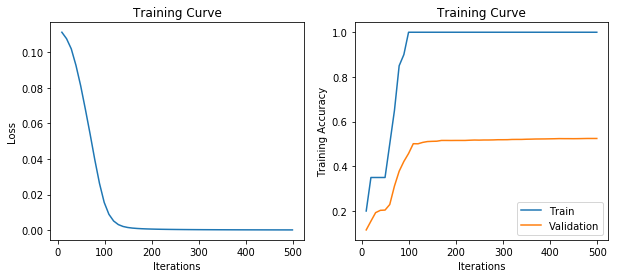

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5246


In [5]:
model = MNISTClassifier()
train(model, mnist_train, mnist_val, num_iters=500)

## Data Normalization

``Data normalization'' means to scale the input features of a neural
network, so that all features are scaled similarly (similar means
and standard deviations). Although data normalization does not directly
prevent overfitting, normalizing your data makes the training
problem easier.

Data normalization is less of an issues for input data -- like images --
where all input features have similar interpretations.
All features of an image are pixel intensities, all of which are scaled
the same way. However, if we were performing prediction of, say, 
housing prices based on a house's number of bedroom, square footage, etc,
we would want each of the features to be scaled similarly. A scale
of mean 0 and standard deviation 1 is one approach. Another approach
is to scale each feature so that they are in the range `[0, 1]`.

The PyTorch transform `transforms.ToTensor()` automatically scales
each pixel intensity to the range `[0, 1]`.
In your lab 2 code, we used the following transform:

In [ ]:
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

This transform subtracts 0.5 from each pixel, and divides the
result by 0.5. So, each pixel intensity will be in the range `[-1, 1]`.
In general, having both positive and negative input values helps
the network trains quickly (because of the way weights are initialized).
Sticking with each pixel being in the range `[0, 1]` is usually fine.

## Data Augmentation

While it is often expensive to gather more data, we can often
programmatically ``generate'' more data points from our existing
data set. We can make small alterations to our training set to obtain
slightly different input data, but that is still valid.
Common ways of obtaining new (image) data include:

- Flipping each image horizontally or vertically (won't work for digit recognition, but might for other tasks)
- Shifting each pixel a little to the left or right
- Rotating the images a little
- Adding noise to the image

... or even a combination of the above. For demonstration purposes, let's randomly
rotate our digits a little to get new training samples.

Here are the 20 images in our training set:

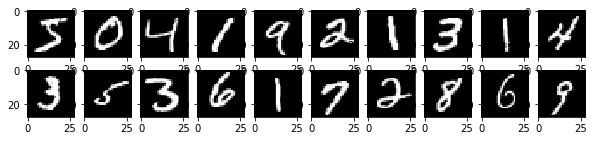

In [6]:
def show20(data):
    plt.figure(figsize=(10,2))
    for n, (img, label) in enumerate(data):
        if n >= 20:
            break
        plt.subplot(2, 10, n+1)
        plt.imshow(img)

mnist_imgs = datasets.MNIST('data', train=True, download=True)
show20(mnist_imgs)

Here are the 20 images in our training set, each rotated randomly, by up to 25 degrees.

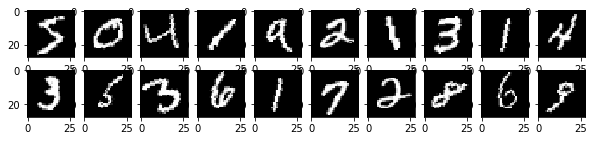

In [7]:
mnist_new = datasets.MNIST('data', train=True, download=True, 
                           transform=transforms.RandomRotation(25))
show20(mnist_new)

If we apply the transformation again, we can get images with different rotations:

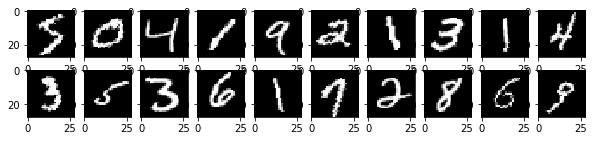

In [13]:
mnist_new = datasets.MNIST('data', train=True, download=True, transform=transforms.RandomRotation(25))
show20(mnist_new)

We can augment our data set by, say, randomly rotating each training data point 100 times:

In [9]:
augmented_train_data = []

my_transform = transforms.Compose([
    transforms.RandomRotation(25),
    transforms.ToTensor(),
])

for i in range(100):
    mnist_new = datasets.MNIST('data', train=True, download=True, transform=my_transform)
    for j, item in enumerate(mnist_new):
        if j >= 20:
            break
        augmented_train_data.append(item)

len(augmented_train_data)

2000

We obtain a better validation accuracy after training on our expanded dataset.

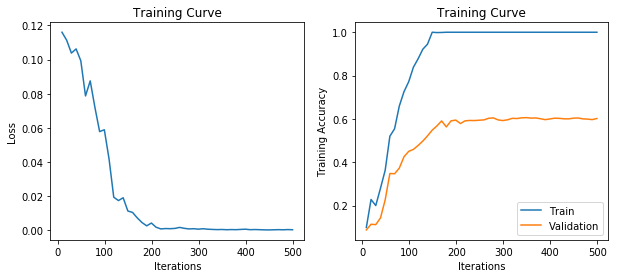

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.6018


In [10]:
model = MNISTClassifier()
train(model, augmented_train_data, mnist_val, num_iters=500)

## Weight Decay

A more interesting technique that prevents overfitting is the idea of weight decay.
The idea is to **penalize large weights**. We avoid large weights, because large weights
mean that the prediction relies a lot on the content of one pixel, or on one unit. Intuitively,
it does not make sense that the classification of an image should depend heavily on the 
content of one pixel, or even a few pixels.

Mathematically, we penalize large weights by adding an extra term to the loss function,
the term can look like the following:

- $L^1$ regularization: $\sum_k |w_k|$
    - Mathematically, this term encourages weights to be exactly 0
- $L^2$ regularization: $\sum_k w_k^2$ 
    - Mathematically, in each iteration the weight is pushed towards 0
- Combination of $L^1$ and $L^2$ regularization: add a term $\sum_k |w_k| + w_k^2$  to the loss function.

In PyTorch, weight decay can also be done automatically inside an optimizer. The parameter `weight_decay`
of `optim.SGD` and most other optimizers uses $L^2$ regularization for weight decay. The value of the
`weight_decay` parameter is another tunable hyperparameter.

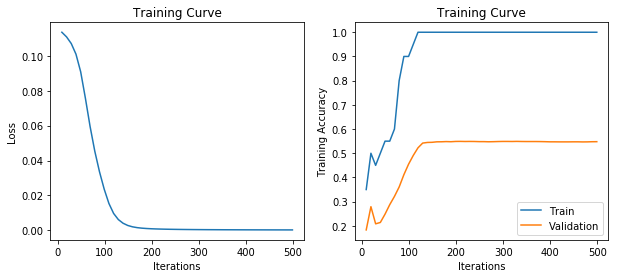

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5478


In [11]:
model = MNISTClassifier()
train(model, mnist_train, mnist_val, num_iters=500, weight_decay=0.001)

## Dropout

Yet another way to prevent overfitting is to build **many** models, then average
their predictions at test time. Each model might have a different set of
initial weights.

We won't show an example of model averaging here. Instead, we will show another 
idea that sounds drastically different on the surface.

This idea is called **dropout**: we will randomly "drop out", "zero out", or "remove" a portion
of neurons from each training iteration.

![](imgs/dropout.png)

In different iterations of training, we will drop out a different set of neurons.

The technique has an effect of preventing weights from being overly dependent on
each other: for example for one weight to be unnecessarily large to compensate for
another unnecessarily large weight with the opposite sign. Weights are encouraged
to be "more independent" of one another.

During test time though, we will not drop out any neurons; instead we will use
the entire set of weights. This means that our training time and test time behaviour
of dropout layers are *different*. In the code for the function `train` and `get_accuracy`,
we use `model.train()` and `model.eval()` to flag whether we want the model's training behaviour,
or test time behaviour.

While unintuitive, using all connections is a form
of model averaging! We are effectively averaging over many different networks
of various connectivity structures.

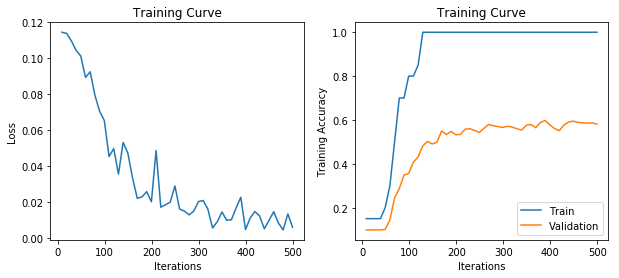

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.5814


In [14]:
class MNISTClassifierWithDropout(nn.Module):
    def __init__(self):
        super(MNISTClassifierWithDropout, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
        self.dropout1 = nn.Dropout(0.4) # drop out layer with 20% dropped out neuron
        self.dropout2 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.4)
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        activation1 = F.relu(self.layer1(self.dropout1(flattened)))
        activation2 = F.relu(self.layer2(self.dropout2(activation1)))
        output = self.layer3(self.dropout3(activation2))
        return output

model = MNISTClassifierWithDropout()
train(model, mnist_train, mnist_val, num_iters=500)